# Import Libraries & Load Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.feature_selection import RFECV
from scipy.stats import randint, uniform

In [2]:
# Load the dataset
df = pd.read_csv('challenge_dataset.csv')

# Part 1: Exploratory Data Analysis (EDA)

## a) Initial Examination

In [3]:
# Shape of the df
df.shape

(4661, 18)

In [4]:
# Display the first few rows of the dataset
df.head()

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,55388,5.0,Mobile Phone,1,9.0,Debit Card,4.0,4,Mobile Phone,3.0,3,0.0,15.0,2.0,2.0,4.0,159.77,0.0
1,52565,2.0,Phone,1,15.0,CC,NaN,3,Mobile,3.0,10,0.0,17.0,0.0,1.0,2.0,129.74,0.0
2,50690,13.0,Mobile Phone,1,20.0,Credit Card,2.0,4,Others,3.0,2,0.0,NaN,4.0,4.0,9.0,296.26,0.0
3,52456,NaN,Phone,1,8.0,Debit Card,3.0,3,Mobile,5.0,2,1.0,12.0,1.0,1.0,0.0,120.74,1.0
4,51153,19.0,Mobile Phone,1,8.0,Credit Card,2.0,3,Others,1.0,8,1.0,NaN,1.0,2.0,2.0,293.28,0.0


In [5]:
# Overview of the dataset structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4661 entries, 0 to 4660
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   4661 non-null   int64  
 1   Tenure                       4430 non-null   float64
 2   PreferredLoginDevice         4661 non-null   object 
 3   CityTier                     4661 non-null   int64  
 4   WarehouseToHome              4444 non-null   float64
 5   PreferredPaymentMode         4661 non-null   object 
 6   HourSpendOnApp               4453 non-null   float64
 7   NumberOfDeviceRegistered     4661 non-null   int64  
 8   PreferedOrderCat             4577 non-null   object 
 9   SatisfactionScore            4283 non-null   float64
 10  NumberOfAddress              4661 non-null   int64  
 11  Complain                     4559 non-null   float64
 12  OrderAmountHikeFromlastYear  4429 non-null   float64
 13  CouponUsed        

In [6]:
# Summary statistics for numerical columns
print(df.describe(include='all'))

          CustomerID       Tenure PreferredLoginDevice     CityTier  \
count    4661.000000  4430.000000                 4661  4661.000000   
unique           NaN          NaN                    3          NaN   
top              NaN          NaN         Mobile Phone          NaN   
freq             NaN          NaN                 2294          NaN   
mean    52807.890796    10.239955                  NaN     1.635915   
std      1632.022072     8.571560                  NaN     0.907663   
min     50001.000000     0.000000                  NaN     1.000000   
25%     51386.000000     2.000000                  NaN     1.000000   
50%     52813.000000     9.000000                  NaN     1.000000   
75%     54216.000000    16.000000                  NaN     3.000000   
max     55630.000000    61.000000                  NaN     3.000000   

        WarehouseToHome PreferredPaymentMode  HourSpendOnApp  \
count       4444.000000                 4661     4453.000000   
unique             

In [7]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
CustomerID                       0
Tenure                         231
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                217
PreferredPaymentMode             0
HourSpendOnApp                 208
NumberOfDeviceRegistered         0
PreferedOrderCat                84
SatisfactionScore              378
NumberOfAddress                  0
Complain                       102
OrderAmountHikeFromlastYear    232
CouponUsed                     203
OrderCount                     211
DaySinceLastOrder              252
CashbackAmount                 121
Churn                           27
dtype: int64


### Check for 'Churn' column distribution

In [8]:
print("Unique values in 'Churn':", df['Churn'].unique())
print("Counts of each category in 'Churn':")
print(df['Churn'].value_counts())

churn_counts = df['Churn'].value_counts(normalize=True) * 100
print("\nProportion of each category in 'Churn':")
print(churn_counts)  # Imbalanced Class

missing_churn = df['Churn'].isnull().sum()
total_rows = df.shape[0]
missing_proportion = (missing_churn / total_rows) * 100

print(f"\nMissing values in 'Churn': {missing_churn} ({missing_proportion:.2f}%)")

Unique values in 'Churn': [ 0.  1. nan]
Counts of each category in 'Churn':
0.0    3860
1.0     774
Name: Churn, dtype: int64

Proportion of each category in 'Churn':
0.0    83.297367
1.0    16.702633
Name: Churn, dtype: float64

Missing values in 'Churn': 27 (0.58%)


In [9]:
# The Churn column has 27 missing values, representing 0.58% of the total dataset. 
# To ensure the integrity of the analysis and modeling, removed these rows, 
# resulting in a complete dataset for further exploration and predictive modeling.

# Remove rows where 'Churn' is NaN
print(f"Original shape: {df.shape}")
df = df.dropna(subset=['Churn'])

# Display the shape of the original and cleaned DataFrame

print(f"Shape after removing NaNs in 'Churn': {df.shape}")

# Check if any NaN values remain in the 'Churn' column
print("\nMissing values in 'Churn' after cleaning:")
print(df['Churn'].isnull().sum())

Original shape: (4661, 18)
Shape after removing NaNs in 'Churn': (4634, 18)

Missing values in 'Churn' after cleaning:
0


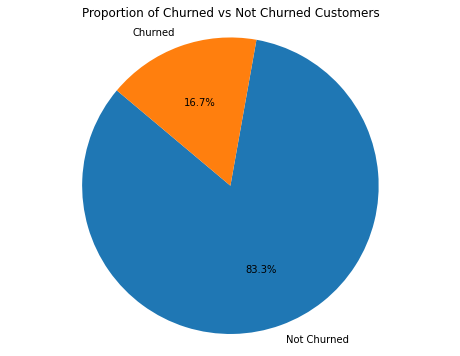

In [10]:
# Visualizing Churn Proportion
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Churned vs Not Churned Customers')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [11]:
# Display unique values for each column
unique_values = {col: df[col].unique() for col in df.columns}
for col, unique in unique_values.items():
    print(f"Unique values in '{col}': {unique}")

Unique values in 'CustomerID': [55388 52565 50690 ... 55115 55056 53411]
Unique values in 'Tenure': [ 5.  2. 13. nan 19.  1. 14.  6.  0. 31. 21.  9.  3. 23. 27. 12.  8. 10.
 11. 20. 15. 29. 24.  7. 25. 16.  4. 28. 22. 17. 18. 30. 26. 50. 61. 51.
 60.]
Unique values in 'PreferredLoginDevice': ['Mobile Phone' 'Phone' 'Computer']
Unique values in 'CityTier': [1 3 2]
Unique values in 'WarehouseToHome': [  9.  15.  20.   8.   7.  14.  25.  31.  11.  22.   6.  23.  26.  12.
  13.  17.  27.  16.  nan  33.  29.  10.  19.  35.  18.   5.  32.  36.
  24.  21.  30.  34.  28. 127. 126.]
Unique values in 'PreferredPaymentMode': ['Debit Card' 'CC' 'Credit Card' 'UPI' 'E wallet' 'COD' 'Cash on Delivery']
Unique values in 'HourSpendOnApp': [ 4. nan  2.  3.  1.  0.  5.]
Unique values in 'NumberOfDeviceRegistered': [4 3 5 2 1 6]
Unique values in 'PreferedOrderCat': ['Mobile Phone' 'Mobile' 'Others' 'Laptop & Accessory' 'Fashion' 'Grocery'
 nan]
Unique values in 'SatisfactionScore': [ 3.  5.  1.  4. nan  

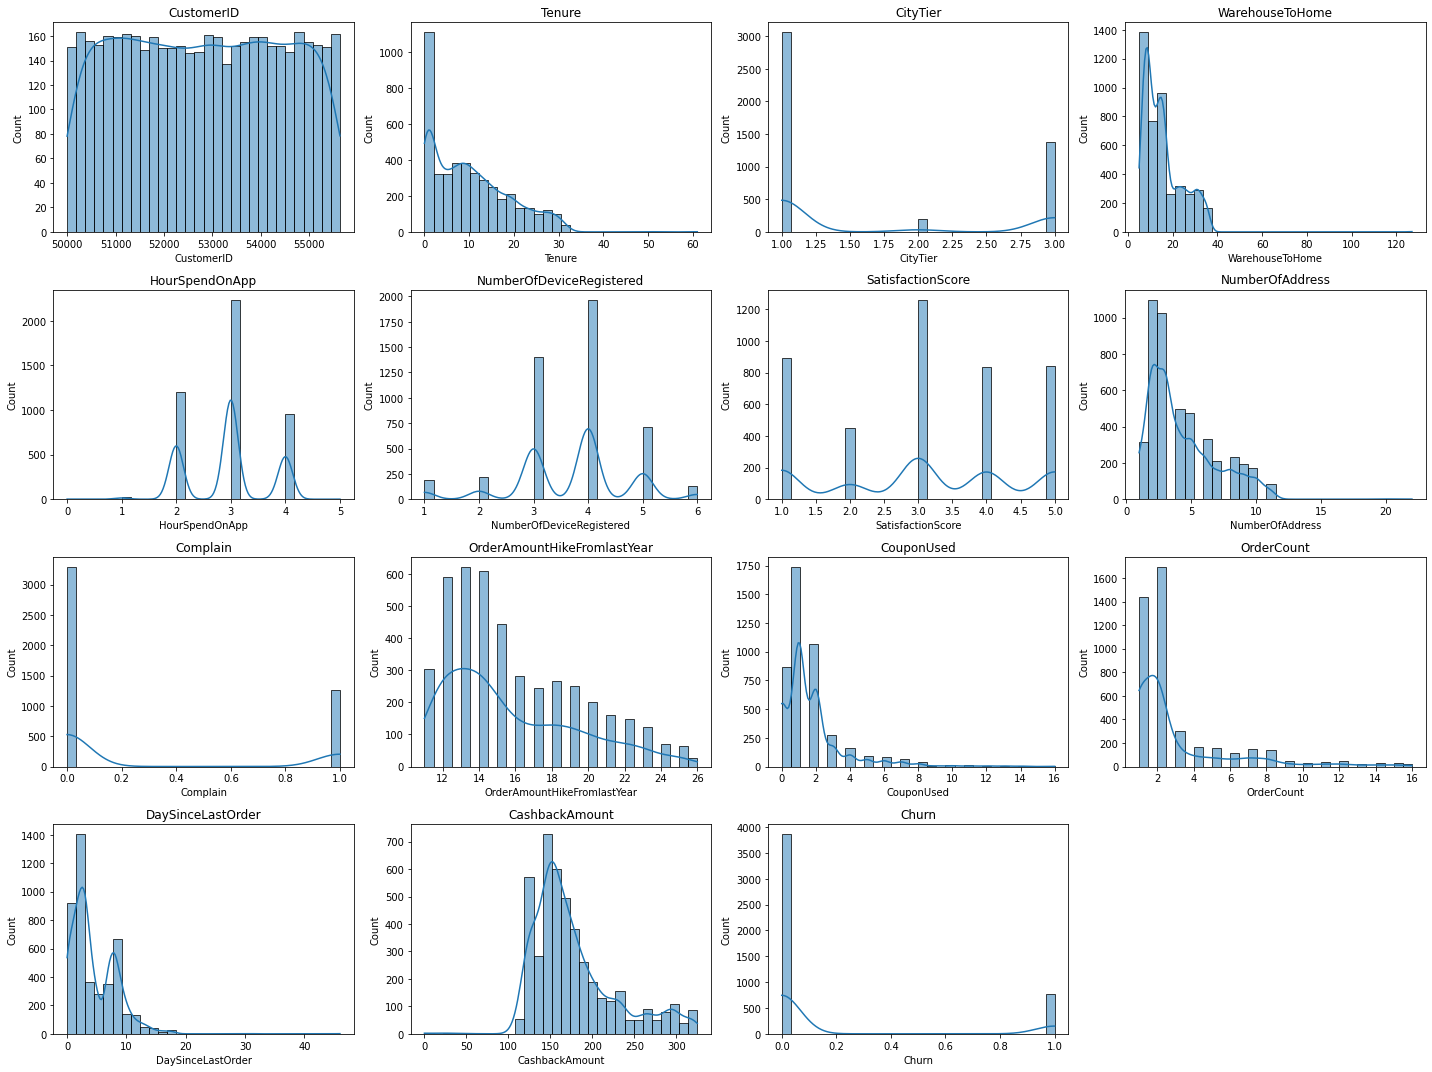

In [12]:
plt.figure(figsize=(20, 15))

# Plot for each numerical feature
for i, column in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

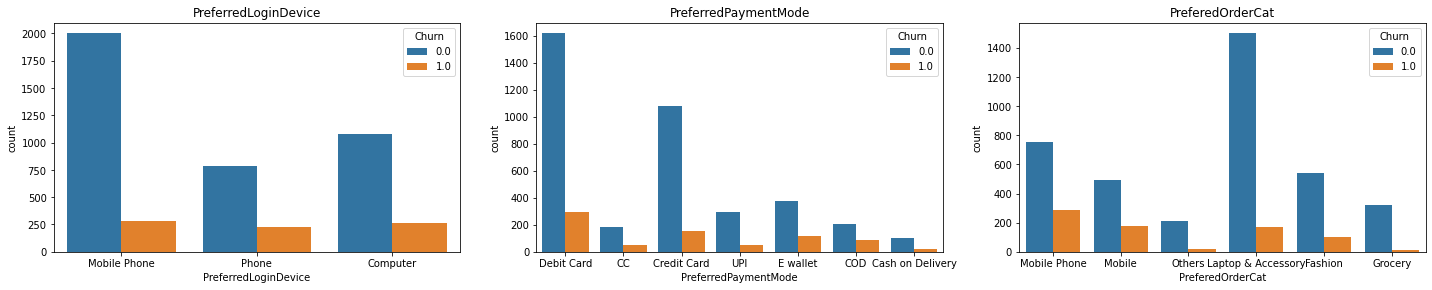

In [13]:
plt.figure(figsize=(20, 15))

# Count plots for categorical features
for i, column in enumerate(df.select_dtypes(include=[object]).columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=column, hue='Churn', data=df)
    plt.title(column)

plt.tight_layout()
plt.show()

## b) Handling Missing Data

In [14]:
def fill_missing_values(df):
    # Identify numerical and categorical columns, excluding 'CustomerID' and 'Churn'
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove 'CustomerID' and 'Churn' from processing
    numerical_columns = [col for col in numerical_columns if col not in ['CustomerID', 'Churn']]
    categorical_columns = [col for col in categorical_columns if col not in ['CustomerID', 'Churn']]

    # Adjust categorical_columns to include 'CouponUsed' if it's treated as categorical
    if 'CouponUsed' in numerical_columns:
        categorical_columns.append('CouponUsed')
        numerical_columns.remove('CouponUsed')

    # Fill missing values for numerical columns
    for column in numerical_columns:
        skewness = df[column].skew()
        
        if abs(skewness) < 0.5:  # Check for normal distribution
            # Fill with mean if normally distributed
            df[column].fillna(df[column].mean(), inplace=True)
            print(f"Filled missing values in '{column}' with mean: {df[column].mean()}")
        else:
            # Fill with median if not normally distributed
            df[column].fillna(df[column].median(), inplace=True)
            print(f"Filled missing values in '{column}' with median: {df[column].median()}")
    
    # Fill missing values for categorical columns
    for column in categorical_columns:
        mode_value = df[column].mode()[0]  # Get the mode (most frequent value)
        df[column].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{column}' with mode: {mode_value}")

# Call the function to fill missing values
fill_missing_values(df)

Filled missing values in 'Tenure' with median: 9.0
Filled missing values in 'CityTier' with median: 1.0
Filled missing values in 'WarehouseToHome' with median: 14.0
Filled missing values in 'HourSpendOnApp' with mean: 2.931813050349966
Filled missing values in 'NumberOfDeviceRegistered' with mean: 3.688605955977557
Filled missing values in 'SatisfactionScore' with mean: 3.0663086621526965
Filled missing values in 'NumberOfAddress' with median: 3.0
Filled missing values in 'Complain' with median: 0.0
Filled missing values in 'OrderAmountHikeFromlastYear' with median: 15.0
Filled missing values in 'OrderCount' with median: 2.0
Filled missing values in 'DaySinceLastOrder' with median: 3.0
Filled missing values in 'CashbackAmount' with median: 163.38
Filled missing values in 'PreferredLoginDevice' with mode: Mobile Phone
Filled missing values in 'PreferredPaymentMode' with mode: Debit Card
Filled missing values in 'PreferedOrderCat' with mode: Laptop & Accessory
Filled missing values in 'C

In [15]:
## c) Check Data After Filling Missing Values
print("\nMissing values after filling:")
print(df.isnull().sum())


Missing values after filling:
CustomerID                     0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
Churn                          0
dtype: int64


## c) Correlation Analysis

In [16]:
def plot_correlation_heatmap(df, threshold=0.7):
    """
    Calculate and plot the correlation heatmap of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): The threshold for displaying correlated pairs.
    
    Returns:
    None
    """
    # Calculate the correlation matrix
    correlation = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Draw the heatmap for the complete correlation matrix
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

    # Title for the heatmap
    plt.title('Complete Correlation Heatmap', fontsize=16)
    plt.show()

    # Find and print correlated pairs
    correlated_pairs = []

    # Loop through the correlation matrix and find correlated columns
    for i in range(len(correlation.columns)):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > threshold:
                correlated_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

    # Print the correlated column pairs
    print("Columns with correlation greater than", threshold, "or less than", -threshold, ":")
    if correlated_pairs:
        for col1, col2, corr_value in correlated_pairs:
            print(f"{col1} and {col2}: {corr_value:.2f}")
    else:
        print("None")

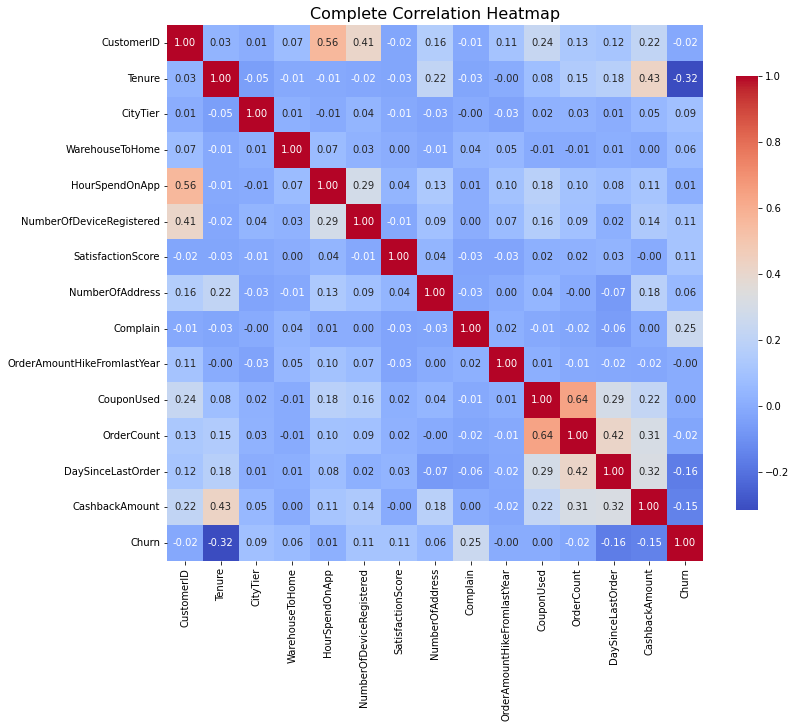

Columns with correlation greater than 0.7 or less than -0.7 :
None


In [17]:
# Example of using the function
plot_correlation_heatmap(df, threshold=0.7)

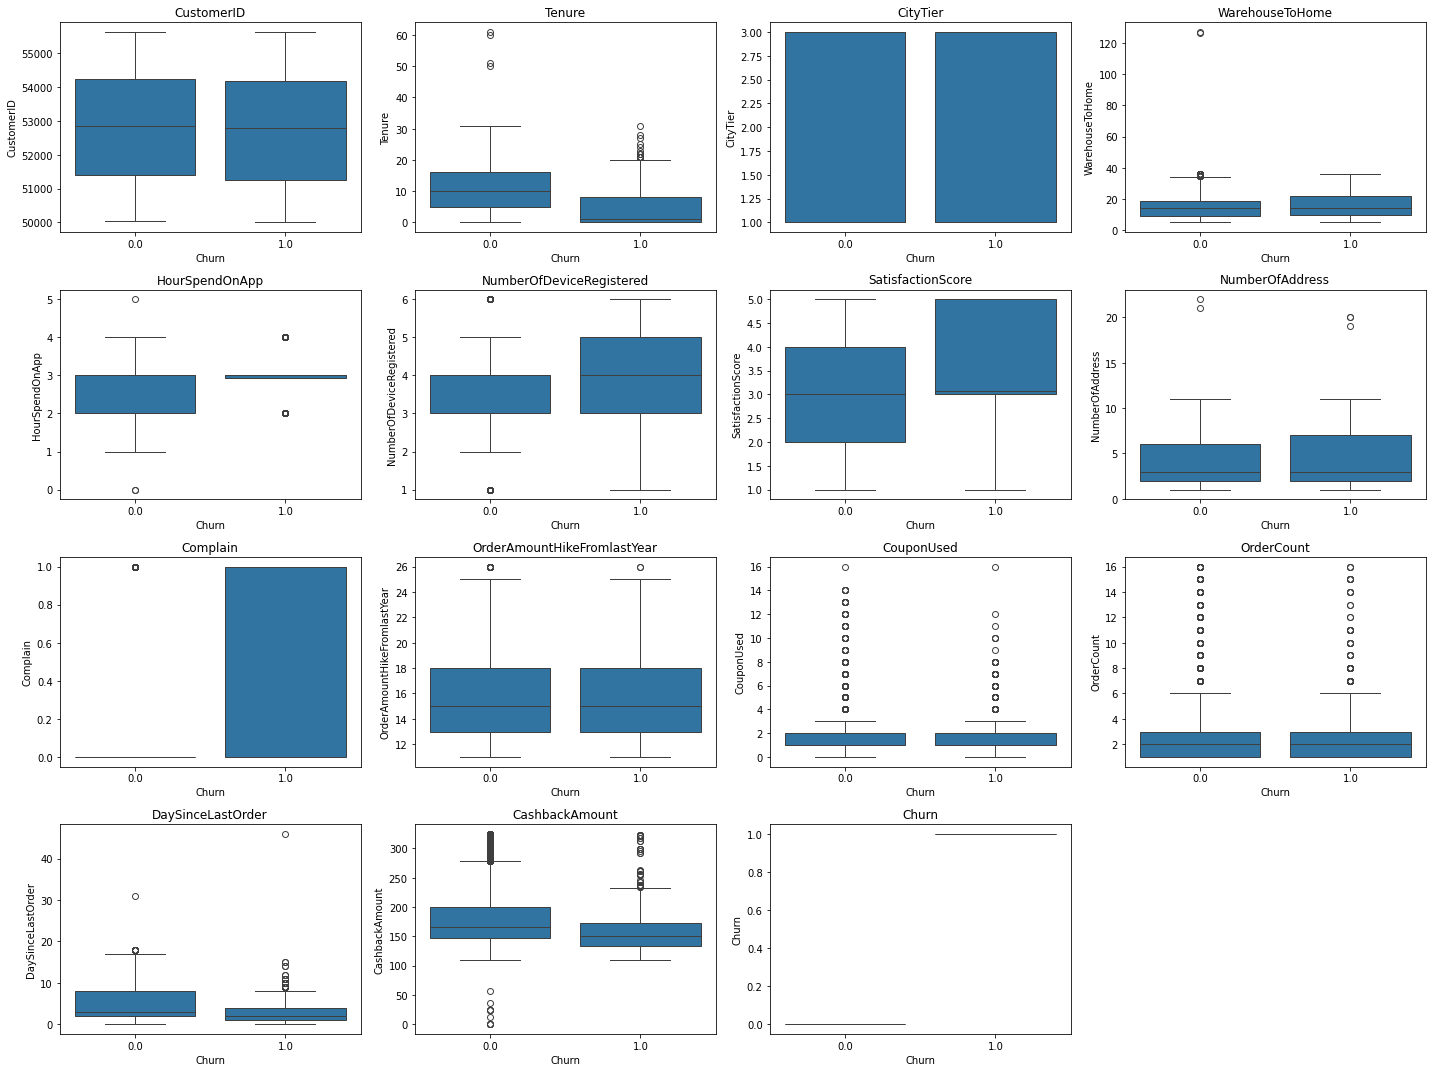

In [18]:
# Box plots for numerical features against Churn
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='Churn', y=column, data=df)
    plt.title(column)
plt.tight_layout()
plt.show()

## d) Feature Engineering - Create Additional Features

In [19]:
def create_features(df):
    """Creates new features RecencyScore, EngagementScore, and DistanceCategory."""
    
    # Helper function to categorize distance
    def categorize_distance(distance):
        """Categorizes distance into 'Close', 'Moderate', or 'Far'."""
        if distance <= 5:
            return 'Very Close'
        elif 5 < distance <= 10:
            return 'Close'
        elif 10 < distance <= 20:
            return 'Moderate'
        elif 20 < distance <= 30:
            return 'Far'
        else:
            return 'Very Far'

    # Check if 'DaySinceLastOrder' exists in DataFrame
    if 'DaySinceLastOrder' in df.columns:
        # Creating the RecencyScore from DaySinceLastOrder
        df['RecencyScore'] = (df['DaySinceLastOrder'].max() - df['DaySinceLastOrder']) / df['DaySinceLastOrder'].max()
        df['RecencyScore'] = df['RecencyScore'].fillna(0)  # Fill NaN with 0
    
    # Creating Engagement Score
    df['EngagementScore'] = df['HourSpendOnApp'] * df['OrderCount']

    # Creating DistanceCategory
    if 'WarehouseToHome' in df.columns:
        df['DistanceCategory'] = df['WarehouseToHome'].apply(categorize_distance)
    
    return df

In [20]:
# Create new features
df = create_features(df)
df.columns, df.head()

(Index(['CustomerID', 'Tenure', 'PreferredLoginDevice', 'CityTier',
        'WarehouseToHome', 'PreferredPaymentMode', 'HourSpendOnApp',
        'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
        'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
        'Churn', 'RecencyScore', 'EngagementScore', 'DistanceCategory'],
       dtype='object'),
    CustomerID  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
 0       55388     5.0         Mobile Phone         1              9.0   
 1       52565     2.0                Phone         1             15.0   
 2       50690    13.0         Mobile Phone         1             20.0   
 3       52456     9.0                Phone         1              8.0   
 4       51153    19.0         Mobile Phone         1              8.0   
 
   PreferredPaymentMode  HourSpendOnApp  NumberOfDeviceRegistered  \
 0           Debit Card      

In [21]:
# plot_correlation_heatmap(df, threshold=0.7)

# Part 2: Churn Prediction

## a) Data Preparation - Encoding & Train Test Split

In [25]:
# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split the data into features and target variable
X = df.drop(columns=['Churn'])  # Drop the target column
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print(f"Class distribution after SMOTE: {y_train_resampled.value_counts()}")

Class distribution after SMOTE: 0.0    2701
1.0    2701
Name: Churn, dtype: int64


## b) Feature Scaling

In [26]:
# Initialize StandardScaler for scaling features
scaler = StandardScaler()

# Scale both the training and testing sets
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## c) Classifier Initialization

In [27]:
# Initialize a dictionary to store results
results = {}

# Define the classifiers to use in the specified order
classifiers = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
}

## d) Model Training & Feature Selection(RFECV)
## e) Hyperparameter Tuning(RandomizedSearchCV)
## f) Evaluation with Custom Threshold

In [28]:
####################### d) Model Training & Feature Selection(RFECV)  ######################
for name, clf in classifiers.items():
    print(f"\n--- Training {name} ---")

    # Apply RFECV for Logistic Regression, Random Forest, and XGBoost
    if name in ['LogisticRegression', 'RandomForest', 'XGBoost']:
        rfecv = RFECV(estimator=clf, step=5, cv=5, scoring='roc_auc', n_jobs=-1)
        X_train_rfecv = rfecv.fit_transform(X_train_resampled_scaled, y_train_resampled)
        X_test_rfecv = rfecv.transform(X_test_scaled)

        # Get the selected features after RFECV
        selected_features = X.columns[rfecv.get_support()]
        print(f"Selected Features after RFECV for {name}: {selected_features}")
    else:
        # Use all features for classifiers like SVC (not in this loop)
        X_train_rfecv = X_train_resampled_scaled
        X_test_rfecv = X_test_scaled
        selected_features = X.columns.tolist()
        print(f"Using all features for {name}.")

####################### Hyperparameter Tuning for each model - RandomizedSearchCV ######################
    if name == 'RandomForest':
        param_distributions = {
            'n_estimators': randint(50, 501),
            'max_depth': randint(3, 31),
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 5),
        }
    elif name == 'LogisticRegression':
        param_distributions = {
            'C': np.logspace(-4, 4, 20),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    elif name == 'XGBoost':
        param_distributions = {
            'n_estimators': randint(50, 501),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 31),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5)
        }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        scoring='roc_auc',
        verbose=2,
        random_state=42
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train_rfecv, y_train_resampled)

    # Get the best model from RandomizedSearchCV
    best_model = random_search.best_estimator_

###################### Evaluation with Custom Threshold  ######################

    # Predictions for the test set with custom threshold
    custom_threshold = 0.5  # This threshold can be adjusted
    y_pred_proba_test = best_model.predict_proba(X_test_rfecv)[:, 1]
    y_pred_test = (y_pred_proba_test >= custom_threshold).astype(int)

    # Evaluation Metrics for the Test Set
    print(f"\n--- Test Set Metrics for {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred_test), 2)}")
    print(f"Precision: {round(precision_score(y_test, y_pred_test), 2)}")
    print(f"Recall: {round(recall_score(y_test, y_pred_test), 2)}")
    print(f"F1 Score: {round(f1_score(y_test, y_pred_test), 2)}")
    print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred_proba_test), 2)}")
    print("Classification Report:\n", classification_report(y_test, y_pred_test, digits=2))

    # Store results
    results[name] = {
        'Best Model': best_model,
        'Best Hyperparameters': random_search.best_params_,
        'Test ROC AUC Score': round(roc_auc_score(y_test, y_pred_proba_test), 2)
    }
    
    # Get feature importance for RandomForest and XGBoost
    if name in ['RandomForest', 'XGBoost']:
        # Feature importance for RandomForest
        if name == 'RandomForest':
            feature_importances = best_model.feature_importances_
            results[name]['Feature Importances'] = dict(zip(selected_features, feature_importances))

        # Feature importance for XGBoost
        elif name == 'XGBoost':
            feature_importances = best_model.feature_importances_
            results[name]['Feature Importances'] = dict(zip(selected_features, feature_importances))

    # For Logistic Regression, calculate feature importance based on coefficients
    elif name == 'LogisticRegression':
        feature_importances = np.abs(best_model.coef_[0])
        results[name]['Feature Importances'] = dict(zip(selected_features, feature_importances))



--- Training LogisticRegression ---
Selected Features after RFECV for LogisticRegression: Index(['CustomerID', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'RecencyScore',
       'EngagementScore', 'PreferredLoginDevice_Mobile Phone',
       'PreferredLoginDevice_Phone', 'PreferredPaymentMode_COD',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory',
       'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'DistanceCategory_Far',
       'DistanceCategory_Moderate', 'DistanceCategory_Very Close',
       'DistanceCategory_V

d:\Anaconda3\envs\mg38\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



--- Test Set Metrics for LogisticRegression ---
Confusion Matrix:
 [[1040  119]
 [ 103  129]]
Accuracy: 0.84
Precision: 0.52
Recall: 0.56
F1 Score: 0.54
ROC AUC Score: 0.85
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      1159
         1.0       0.52      0.56      0.54       232

    accuracy                           0.84      1391
   macro avg       0.72      0.73      0.72      1391
weighted avg       0.84      0.84      0.84      1391


--- Training RandomForest ---
Selected Features after RFECV for RandomForest: Index(['CustomerID', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'RecencyScore',
       'EngagementScore', 'PreferredLoginDevice_Mobile Phone',
       'PreferredLoginDevice_Phone', '

d:\Anaconda3\envs\mg38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:04:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Selected Features after RFECV for XGBoost: Index(['CustomerID', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'RecencyScore',
       'EngagementScore', 'PreferredLoginDevice_Mobile Phone',
       'PreferredLoginDevice_Phone', 'PreferredPaymentMode_COD',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory',
       'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile Phone',
       'PreferedOrderCat_Others', 'DistanceCategory_Far',
       'DistanceCategory_Moderate', 'DistanceCategory_Very Close',
       'DistanceCategory_Very Far'],
      dtype='object')
Fitting 5 folds

d:\Anaconda3\envs\mg38\lib\site-packages\xgboost\core.py:158: UserWarning: [17:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Test Set Metrics for XGBoost ---
Confusion Matrix:
 [[1129   30]
 [  66  166]]
Accuracy: 0.93
Precision: 0.85
Recall: 0.72
F1 Score: 0.78
ROC AUC Score: 0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1159
         1.0       0.85      0.72      0.78       232

    accuracy                           0.93      1391
   macro avg       0.90      0.84      0.87      1391
weighted avg       0.93      0.93      0.93      1391



## g) Results Output

In [29]:
# Display the results
for model_name, metrics in results.items():
    print(f"\n--- {model_name} Results ---")
    print(f"Best Hyperparameters: {metrics['Best Hyperparameters']}")
    print(f"Test ROC AUC Score: {metrics['Test ROC AUC Score']}")
    print("Feature Importances:", metrics['Feature Importances'])


--- LogisticRegression Results ---
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.03359818286283781}
Test ROC AUC Score: 0.85
Feature Importances: {'CustomerID': 0.013891204164316577, 'Tenure': 1.1282021435799818, 'CityTier': 0.17696188159777723, 'WarehouseToHome': 0.7808086327551067, 'HourSpendOnApp': 0.05940866282703771, 'NumberOfDeviceRegistered': 0.26807718782016404, 'SatisfactionScore': 0.3937718064743815, 'NumberOfAddress': 0.3928337940870164, 'Complain': 0.6724253370365836, 'OrderAmountHikeFromlastYear': 0.007512530535955726, 'CouponUsed': 0.08301639407121661, 'OrderCount': 0.18460758785126094, 'DaySinceLastOrder': 0.1887524037292827, 'CashbackAmount': 0.42307948150556857, 'RecencyScore': 0.1887524037292819, 'EngagementScore': 0.01596282761596076, 'PreferredLoginDevice_Mobile Phone': 0.441907347449852, 'PreferredLoginDevice_Phone': 0.3933102347811164, 'PreferredPaymentMode_COD': 0.34441822749618395, 'PreferredPaymentMode_Cash on Delivery': 0.2762852335621

1. Data Preprocessing and Class Balance
The class imbalance in the dataset was handled using SMOTE, resulting in equal representation of churners and non-churners. This allowed the models to learn patterns related to customer churn without being biased toward the majority class.
2. Model Performance Overview
Logistic Regression
Logistic Regression showed decent performance in identifying churners. It achieved reasonable accuracy but had a tendency to classify a number of non-churners as churners, leading to lower precision. However, it was able to catch a significant portion of the actual churners, which is important for the business objective.
Random Forest
The Random Forest model performed notably well, with strong overall predictive power. It struck a good balance between correctly identifying churners and minimizing the number of false positives. The model demonstrated reliable accuracy and performed well in terms of detecting both churners and non-churners effectively.
XGBoost
Similar to Random Forest, XGBoost also provided excellent results, combining high accuracy with robust precision and recall. It slightly outperformed Random Forest in identifying churners with fewer false positives, making it an effective model for churn prediction.